<center>
# Machine Learning
## Project 1
## Neural Network Classifier with 1 Hidden Layer
### Dimitris Papatheodorou 3130162


#### Libraries

In [157]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
# import numba  # using @numba.jit before a function it is compiled using numba and sometimes performs better
# On my computer it was slightly faster but took a lot of time compiling, so I didn't use it finally
%matplotlib inline

#### Load MNIST data for handwritten digits

In [123]:
def load_mnist_data(type_, K=10):
    X = np.loadtxt("mnist/"+type_+"0.txt")
    T = np.zeros((X.shape[0], K))
    T[:,0] = 1
    for i in range(1,10):
        X_ = np.loadtxt("mnist/"+type_+"%d.txt" % i)
        T_ = np.zeros((X_.shape[0], K))
        T_[:,i] = 1
        X = np.concatenate((X, X_), axis=0)
        T = np.concatenate((T, T_), axis=0)
    # normalize to [0,1]
    X = X/255.0
    return X, T

X_train, T_train = load_mnist_data("train")
X_test, T_test = load_mnist_data("test")

#### Neural Network Classifier implementation
(Σε κάποιες εκδόσεις μπορεί να μη μεταγλωττίζεται σωστά ο latex κώδικας)

This implementation follows the interface of NumPy classifiers.
##### Basic functions:
- **fit**  fits the data to the classifier
- **train**  does the training process using _gradient ascent_ to minimize the cost function via back propagation
- **predict**  does the testing by predicting the classes of unknown data
- **gradcheck**  tests the analytical gradients computation by comparing them to a sample of numerical gradient computations

##### Helper functions:
- **softmax**  implements the _softmax_ function in a numerically stable manner
- **activation**  wraps around the function used for _activation_ - here $$cos(x)$$
- **deriv_activation**  wraps around the derivative of the activation function - here $$cos'(x) = -sin(x)$$
- **cost_function**  implements the *cost function* of the classifier in a numerically stable manner - here <br><br>
$$E(w) = \sum_{n=1}^{N}\sum_{k=1}^{K}t_{nk}\log y_{nk} - \frac{\lambda}{2}\lVert w \rVert^2$$<br><br>
- **forward_propagation**  executes the *forward propagation* in the network: <br><br>
    Input propagating to the hidden layer: $ \ \ \ \ \ $ $A_1 = X(W^{(1)})^T$ <br>
    Activation in the hidden layer: $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $ $Z = cos(A_1) + ones$ <br>
    Propagation from hidden layer to output: $\  $ $A_2 = Z(W^{(2)})^T$ <br><br>

- **grad_dW1**  implementation of the gradient of $E(w)$ against $W^{(1)}$ <br><br>
$$\frac{\partial}{\partial W^{1}} E(W) = (-(T-Y)W^{(2)}\circ sin(X(W^{(1)})^T))^T - \lambda W^{(1)} $$ <br><br>
- **grad_dW2**  implementation of the gradient of $E(w)$ against $W^{(2)}$ <br><br>
$$\frac{\partial}{\partial W^{2}} E(W) = (T-Y)^Tcos(X(W^{(1)})^T + ones) - \lambda W^{(2)}$$<br><br>

In [124]:
class NeuralNetworkClassifier:
    
    def __init__(self, hidden_units_num=100, lambda_=0.05, learning_rate=1e-4, tol=1e-8, max_iter=400):
        self.M = hidden_units_num
        self.lambda_ = lambda_
        self.eta = learning_rate
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, X, T):
        N = X.shape[0]
        D = X.shape[1]
        K = T.shape[1]
        ones = np.ones((N,1))
        X = np.append(ones, X, axis=1)
        self.X = X
        self.T = T
        #self.eta /= N
        # Random initialization of the weights
        np.random.seed(0)
        self.W1 = np.random.randn(self.M, D+1) / np.sqrt(D+1)
        self.W2 = np.random.randn(K, self.M+1) / np.sqrt(self.M+1)
           
    def train(self):
        if self.X is None or self.T is None:
            print("Please fit some data to the model first")
            return
        # learning procedure
        # We need to maximize the cost function using gradient ascent to find the optima for the weight parameters
        Ew_old = float('-inf')

        for it in range(1, self.max_iter+1):
            # forward propagation calculations
            Ew = self.cost_function()
            
            print('Iteration: %d, Cost function: %f\n' % (it, Ew))

            if np.abs((Ew - Ew_old)/Ew) < self.tol:
                break
                
            # backpropagation calculations
            gradEw_dW2 = self.grad_dW2()
            gradEw_dW1 = self.grad_dW1()
            self.W2 += self.eta * gradEw_dW2
            self.W1 += self.eta * gradEw_dW1
            Ew_old = Ew
                 
    def predict(self, X_test):
        ones = np.ones((X_test.shape[0],1))
        X_test = np.append(ones, X_test, axis=1) 
        Yx = self.forward_propagation(X_test)[-1]
        # mean predictions
        Y_test = NeuralNetworkClassifier.softmax(Yx)
        # hard classification decisions
        T_test = np.argmax(Y_test, axis=1)
        return T_test, Y_test
    
    def softmax(Y):
        assert len(Y.shape) == 2
        M = np.max(Y, axis=1)
        M = M[:, np.newaxis] # necessary step to do broadcasting
        e_x = np.exp(Y - M)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis]
        return e_x / div
     
    def activation(a):
        return np.cos(a)

    def deriv_activation(a):
        return -np.sin(a)
    
    def forward_propagation(self, X=None, idx=0):
        if X is None:
            X = self.X            
        A1 = X @ self.W1.T
        Z = NeuralNetworkClassifier.activation(A1)
        ones = np.ones((Z.shape[0],1))
        Z = np.append(ones, Z, axis=1) 
        A2 = Z @ self.W2.T
        return A1, Z, A2

    def cost_function(self, X=None, T=None, W1=None, W2=None):
        if X is None:
            X = self.X
        if T is None:
            T = self.T
        if W1 is None:
            W1 = self.W1
        if W2 is None:
            W2 = self.W2
            
        Yx = self.forward_propagation(X)[-1]
        M = np.max(Yx, axis=1)
        M = M[:, np.newaxis]
        Ew = np.sum(np.sum(T * Yx)) - np.sum(M) - np.sum(np.log(np.sum(np.exp(Yx - M)))) \
                                                    - (0.5 * self.lambda_) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
        return Ew
 
    def grad_dW2(self, X=None, T=None):
        if X is None:
            X = self.X
        if T is None:
            T = self.T
        _, Z, A2 = self.forward_propagation(X)
        Y = NeuralNetworkClassifier.softmax(A2)
        gradEw_dW2 = (T - Y).T @ Z - self.lambda_ * self.W2
        return gradEw_dW2

    def grad_dW1(self, X=None, T=None):
        if X is None:
            X = self.X
        if T is None:
            T = self.T
        A1, _, A2 = self.forward_propagation(X)
        Y = NeuralNetworkClassifier.softmax(A2)
        Z = NeuralNetworkClassifier.deriv_activation(A1)
        gradEw_dW1 = (((T - Y) @ self.W2[:,1:] * Z)).T @ X - self.lambda_ * self.W1
        return gradEw_dW1
 
    def gradcheck(self, X=None, T=None, epsilon=1e-8):
        if X is None:
            X = self.X
        else:
            ones = np.ones((X.shape[0],1))
            X = np.append(ones, X, axis=1)
        if T is None:
            T = self.T
               
        gradEw_dW2 = self.grad_dW2(X, T);
        gradEw_dW1 = self.grad_dW1(X, T);
        numgradEw_dW2 = np.zeros_like(self.W2)
        numgradEw_dW1 = np.zeros_like(self.W1)
        M, D = self.W1.shape
        K, M_ = self.W2.shape
        # We check if the analytical gradient match the numeric ones
        
        # W2 gradient 
        for i in range(K):
            for j in range(M_):
                a_temp = self.W2;
                a_temp[i,j] += epsilon;
                a = self.cost_function(X, T, W2=a_temp);
                b_temp = self.W2;
                b_temp[i,j] -= epsilon;
                b = self.cost_function(X, T, W2=b_temp);
                numgradEw_dW2[i,j] = (a-b)/(2*epsilon);
        # W1 gradient
        for i in range(M):
            for j in range(D):
                a_temp = self.W1;
                a_temp[i,j] += epsilon;
                a = self.cost_function(X, T, W1=a_temp);
                b_temp = self.W1;
                b_temp[i,j] -= epsilon;
                b = self.cost_function(X, T, W1=b_temp);
                numgradEw_dW1[i,j] = (a-b)/(2*epsilon);

        diff2 = np.abs(gradEw_dW2 - numgradEw_dW2)
        diff1 = np.abs(gradEw_dW1 - numgradEw_dW1)
        print('The maximum absolute norm in the gradcheck of dW2 is', np.max(diff2))
        print('The maximum absolute norm in the gradcheck of dW1 is', np.max(diff1))
        print('The mean diff in the gradcheck of dW2 is', np.mean(diff2))
        print('The mean diff in the gradcheck of dW1 is', np.mean(diff1))
        return gradEw_dW1, gradEw_dW2, numgradEw_dW1, numgradEw_dW2

#### Test the model's classification accuracy by doing class predictions of unknown test data

In [141]:
def test_model(model, X_test, T_test, print_error=False):
    T, _ = model.predict(X_test)
    T_true = np.argmax(T_test, axis=1)
    diff = T_true - T
    error = np.count_nonzero(diff==0)/float(diff.shape[0])
    if print_error:
        print("Accuracy Error:", error)
    return error

#### Create the model using any parameters

In [133]:
model = NeuralNetworkClassifier(lambda_=0.012, learning_rate=5e-1, max_iter=200)

#### Do the gradient check using a small random sample of data
(Βγάζει αρκετά μεγάλο σφάλμα κι ενδεχομένως γι΄αυτό και το test error παρακάτω δεν είναι αρκετά μικρό, αλλά δε μπορώ να εντοπίσω που βρίσκεται, ειδικά στην 2η παράγωγη που είναι απλοϊκή. Ίσως αν έκανα τον υπολογισμό με for loops και όχι με πίνακες, να έβγαινε σωστότερο, αλλά στον υπολογιστή μου έτρεχε υπερβολικά αργά με πολλαπλασιασμό και δεν το δοκίμασα. Αν βρείτε το λάθος μου, πείτε το μου, με τυραννάει απ΄το Πάσχα)

In [108]:
ch = np.random.permutation(X_train.shape[0])
ch = ch[:20]
model.fit(X_train[ch,:], T_train[ch,:])
_,_,_,_ = model.gradcheck()

The maximum absolute norm in the gradcheck of dW2 is 2.7239249245
The maximum absolute norm in the gradcheck of dW1 is 0.457408674958
The mean diff in the gradcheck of dW2 is 1.18628234537
The mean diff in the gradcheck of dW1 is 0.0233783786611


#### Cross validation to determine some good values for $\lambda$ and *number of hidden units*

In [148]:
def simple_validate(model, X, T, split=0.8):
    np.random.shuffle(X)
    split_point = int(X.shape[0] * split) + 1
    X_train_set = X[:split_point]
    T_train_set = T[:split_point]
    X_valid_set = X[split_point:]
    T_valid_set = T[split_point:]
    model.fit(X_train_set, T_train_set)
    print("Let's do a simple validation")
    model.train()
    error = test_model(model, X_valid_set, T_valid_set, True)
    return error

def lambda_calculation(X, T, from_, to_, step_, M):
    error = float('inf')
    best_lambda = -1
    for lambda_ in np.arange(from_,to_,step_):
        print("Check for lambda = %f" % lambda_)
        model = NeuralNetworkClassifier(hidden_units_num=M, lambda_=lambda_, learning_rate=1e-7, max_iter=200)
        err = simple_validate(model, X, T)
        if err < error:
            error = err
            best_lambda = lambda_
    return best_lambda

M_lambda = []
for M in range(200,501,100):
    print("For %d hidden units:" % M)
    bl = lambda_calculation(X_train, T_train, 0, 2.1, 0.1, M)
    #bl = lambda_calculation(X_train, T_train, bl-0.1, bl+0.1, 0.01, M)
    #bl = lambda_calculation(X_train, T_train, bl-0.01, bl+0.01, 0.001, M)
    # this may continue
    M_lambda.append(bl)
    print("Best lambda %f" % bl)

For 200 hidden units:
Check for lambda = 0.000000
Let's do a simple validation
Iteration: 1, Cost function: -76904.252623

Iteration: 2, Cost function: -68236.187650

Iteration: 3, Cost function: -60824.036910

Iteration: 4, Cost function: -54427.865541

Iteration: 5, Cost function: -48863.931464

Iteration: 6, Cost function: -43994.283210

Iteration: 7, Cost function: -39715.096447

Iteration: 8, Cost function: -35948.664188

Iteration: 9, Cost function: -32633.957417

Iteration: 10, Cost function: -29719.169115

Iteration: 11, Cost function: -27162.034538

Iteration: 12, Cost function: -24926.980565

Iteration: 13, Cost function: -22973.961863

Iteration: 14, Cost function: -21264.011789

Iteration: 15, Cost function: -19763.613154

Iteration: 16, Cost function: -18437.982094

Iteration: 17, Cost function: -17258.791277

Iteration: 18, Cost function: -16205.192637

Iteration: 19, Cost function: -15259.623440

Iteration: 20, Cost function: -14407.365558

Iteration: 21, Cost function: 

KeyboardInterrupt: 

In [150]:
# lambdas from previous validation
# Επειδή έτρεχε ΠΟΛΥ αργά, πρόλαβα να βρω μόνο για 100 και 200 units το καλύτερο λάμδα και μόνο αυτό πήρε 3 μέρες να τρέχει
# Δυστυχώς στα labs της σχολής, δεν τρέχει jupyter notebook.
# Οι τιμές των υπόλοιπων 3 είναι τυχαίες και τελικά όχι αρκε΄τα καλές, καθώς βγάζουν μεγάλο error
# Πιθανότατα οι τιμές του λ πρέπει να ΄ναι μικρές, της τάξης του 0.1 και μικρότερες, γιατί αλλιώς εισάγουν μεγάλο bias στο μοντέλο
# και το αποδυναμώνουν

M_lambda = [1.63, 0.1, 1.2, 1.0, 0.5]

In [154]:
print(M_lambda)
errors = []
for i in range(1,6):
    model = NeuralNetworkClassifier(hidden_units_num=i*100, lambda_=M_lambda[i-1])
    model.fit(X_train, T_train)
    model.train()
    errors.append(test_model(model, X_test, T_test))


[1.63, 0.10000000000000001, 1.2, 1.0, 0.5]
Iteration: 1, Cost function: -118774.867466

Iteration: 2, Cost function: -1360686.316237

Iteration: 3, Cost function: -602072.983284

Iteration: 4, Cost function: -562465.440429

Iteration: 5, Cost function: -503973.838117

Iteration: 6, Cost function: -442197.654536

Iteration: 7, Cost function: -395853.163337

Iteration: 8, Cost function: -355392.295853

Iteration: 9, Cost function: -325182.125592

Iteration: 10, Cost function: -302958.173889

Iteration: 11, Cost function: -272925.661515

Iteration: 12, Cost function: -249935.393603

Iteration: 13, Cost function: -228279.140314

Iteration: 14, Cost function: -215309.484524

Iteration: 15, Cost function: -194308.391402

Iteration: 16, Cost function: -181510.267689

Iteration: 17, Cost function: -169382.704192

Iteration: 18, Cost function: -154130.159571

Iteration: 19, Cost function: -142496.465251

Iteration: 20, Cost function: -134257.627733

Iteration: 21, Cost function: -128475.361484


In [170]:
iters = [81, 236, 175, 160, 60] # iterations from previous testing

In [173]:
print(errors)

[0.1051, 0.0992, 0.1066, 0.1002, 0.1017]


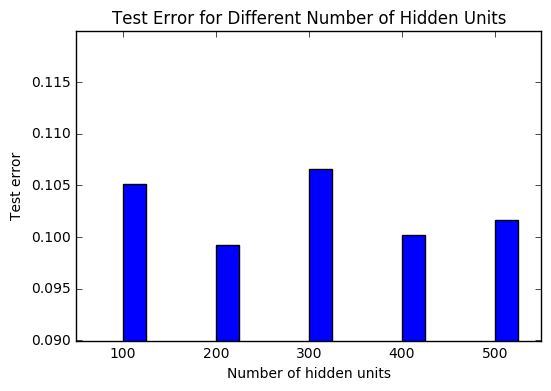

In [166]:
plt.bar([100, 200, 300, 400, 500], errors, 25)
plt.axis([50, 550, 0.09, 0.12])
plt.xlabel('Number of hidden units')
plt.ylabel('Test error')
plt.title('Test Error for Different Number of Hidden Units')

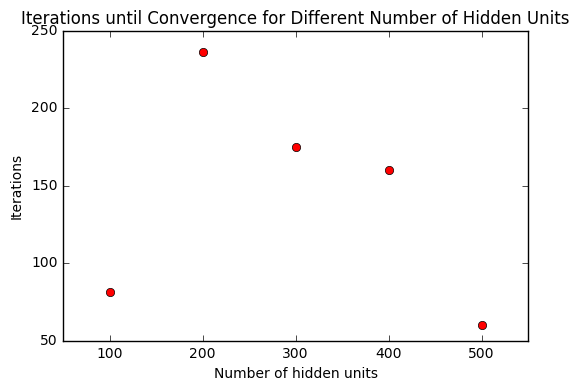

In [172]:
plt.plot([100, 200, 300, 400, 500], iters, 'ro')
plt.axis([50, 550, 50, 250])
plt.xlabel('Number of hidden units')
plt.ylabel('Iterations')
plt.title('Iterations until Convergence for Different Number of Hidden Units')